AC/DC/SOC-OPF Data
---
This notebook is distributed alongside data that was generated using the AI4OPT/OPFGenerator repository. The data consists of several HDF5 files which contain input/solution data, and a JSON file which contains network information.

In the cell below, input the path to the directory containing the data files and the network name (the prefix of the data files).

In [1]:
data_folder = "data/" # path to the folder containing the data files
case_ref = "14_ieee" # 5_pjm or 14_ieee

Then, install `h5py` to parse the data files.

In [ ]:
%pip install h5py

### Parsing functions

The next few cells define functions used for parsing the data.

In [3]:
import h5py
import numpy as np


def parse_hdf5(path, preserve_shape=False):
    """Parse an HDF5 file into a dictionary.

    If `preserve_shape` is `True`, the dictionary will be structured
    to reflect the original structure of the HDF5 file. Otherwise, the
    dictionary will be flat where the keys are the paths to the data
    in the HDF5 file, e.g. d["primal"]["pg"] is under d["primal/pg"].

    Args:
        path (str): Path to the HDF5 file.
        preserve_shape (bool, optional): Whether to preserve the shape of the data. Defaults to False.

    Returns:
        dict: Dictionary containing the data from the HDF5 file.
    """
    dat = dict()

    def read_direct(dataset: h5py.Dataset):
        arr = np.empty(dataset.shape, dtype=dataset.dtype)

        if set(dataset.shape) != {0}:
            dataset.read_direct(arr)

        if arr.dtype.kind in "SO":
            return arr.astype(str)
        else:
            return arr

    def store(name, obj):
        if isinstance(obj, h5py.Group):
            return
        elif isinstance(obj, h5py.Dataset):
            dat[name] = read_direct(obj)
        else:
            raise ValueError(f"Got {type(obj)} under {name}.")

    with h5py.File(path, "r") as f:
        f.visititems(store)

    if preserve_shape:
        # recursively correct the shape of the dictionary
        ret = dict()

        def r_correct_shape(d: dict, ret: dict):
            for k in list(d.keys()):
                if "/" in k:
                    k1, k2 = k.split("/", 1)
                    if k1 not in ret:
                        ret[k1] = dict()
                    r_correct_shape({k2: d[k]}, ret[k1])
                    del d[k]
                else:
                    ret[k] = d[k]

        r_correct_shape(dat, ret)

        return ret
    else:
        return dat


In [4]:
import json
from collections import defaultdict


def parse_json(path, model_type=["ACOPF", "DCOPF", "SOCWRConic"]):
    """Parse the JSON file from OPFGenerator.

    Args:
        path (str)
            Path to the JSON file.
        model_type (Union[str, Sequence[str]])
            The reference solutions to save. Default: ["ACOPF", "DCOPF", "SOCWRConic"].
            If any of the models are not found in the JSON file, a warning will be printed.

    Returns:
        dict: Dictionary containing the parsed data.

    In the JSON file, the data is stored by each individual component.
    So to get generator 1's upper bound on active generation, you'd look at:
    raw_json['data']['gen']['1']['pmax'] and get a float.

    In the parsed version, we aggregate each of the components attributes into numpy arrays.
    So to get generator 1's upper bound on active generation, you'd look at:
    dat['gen']['pmax'][0] and get a the same float as above.
    Note that the index is 0-based and an integer, not 1-based and a string.

    To access the reference solution, pass a model_type (or multiple), then use it as the key.
    """
    dat = dict()

    with open(path, "r") as f:
        raw_json = json.load(f)
        file_data = raw_json["data"]
        dat["meta"] = raw_json["meta"]

        if isinstance(model_type, str):
            model_type = [model_type]

        for mtype in model_type:
            dat[mtype] = raw_json.get(mtype, None)
            if dat[mtype] is None:
                print(f"Reference solution for model type {mtype} not found in ref JSON file.")

    ## meta data
    for key in ["basic_network", "source_type", "name", "source_version", "baseMVA", "per_unit"]:
        dat[key] = file_data[key]

    ## components
    def parse_component(component, index_keys=None):
        if component == "bus" and index_keys is None:
            index_keys = []
        elif index_keys is None:
            index_keys = [f"{component}_bus"]

        dat[f"n_{component}"] = len(file_data[component])
        dat[component] = defaultdict(list)
        for item in sorted(file_data[component].keys(), key=int):
            for k, value in file_data[component][item].items():
                dat[component][k].append(value if k not in index_keys else value - 1)

    parse_component("bus")
    parse_component("gen")
    parse_component("branch", index_keys=["f_bus", "t_bus"])
    parse_component("shunt")
    parse_component("load")

    for component in ["bus", "gen", "branch", "shunt", "load"]:
        dat[component].default_factory = None  # disable defaultdict behavior

        for key, value in dat[component].items():
            if key != "source_id" and not isinstance(value, np.ndarray):
                dat[component][key] = np.array(value)

    return dat

### Read data

The next few cells read ACOPF, DCOPF, and SOCWR dataset files.

In [5]:
# sanity check the files
from pathlib import Path

data_folder = Path(data_folder)
assert data_folder.exists(), f"Data folder not found: {data_folder}"
assert (data_folder / f"{case_ref}_input.h5").exists(), f"Input data file not found: {data_folder / f'{case_ref}_input.h5'}"
assert (data_folder / f"{case_ref}_ACOPF.h5").exists(), f"ACOPF data file not found: {data_folder / f'{case_ref}_ACOPF.h5'}"
assert (data_folder / f"{case_ref}_DCOPF.h5").exists(), f"DCOPF data file not found: {data_folder / f'{case_ref}_DCOPF.h5'}"
assert (data_folder / f"{case_ref}_SOCWRConic.h5").exists(), f"SOCWRConic data file not found: {data_folder / f'{case_ref}_SOCWRConic.h5'}"
assert (data_folder / f"{case_ref}.ref.json").exists(), f"Reference data file not found: {data_folder / f'{case_ref}.ref.json'}"

In [6]:
# read the data
D_input = parse_hdf5(data_folder / f"{case_ref}_input.h5", preserve_shape=True)
D_acp   = parse_hdf5(data_folder / f"{case_ref}_ACOPF.h5", preserve_shape=True)
D_dcp   = parse_hdf5(data_folder / f"{case_ref}_DCOPF.h5", preserve_shape=True)
D_soc   = parse_hdf5(data_folder / f"{case_ref}_SOCWRConic.h5", preserve_shape=True)

ref = parse_json(data_folder / f"{case_ref}.ref.json", model_type=["ACOPF", "DCOPF"])

In [7]:
# check how many inputs are infeasible

ac_infeasible = (D_acp['meta']['termination_status'] != 'LOCALLY_SOLVED') | (D_acp['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_acp['meta']['dual_status'] != 'FEASIBLE_POINT')
ac_feasible = ~ac_infeasible

dc_infeasible = (D_dcp['meta']['termination_status'] != 'OPTIMAL') | (D_dcp['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_dcp['meta']['dual_status'] != 'FEASIBLE_POINT')
dc_feasible = ~dc_infeasible

soc_infeasible = (D_soc['meta']['termination_status'] != 'OPTIMAL') | (D_soc['meta']['primal_status'] != 'FEASIBLE_POINT') | (D_soc['meta']['dual_status'] != 'FEASIBLE_POINT')
soc_feasible = ~soc_infeasible

soc_feasible_ac_infeasible = soc_feasible & ac_infeasible
all_feasible = soc_feasible & ac_feasible & dc_feasible

print(f"ACOPF infeasible: {ac_infeasible.sum()}")
print(f"SOCWRConic infeasible: {soc_infeasible.sum()}")
print(f"DCOPF infeasible: {dc_infeasible.sum()}")
print(f"SOC Feasible and AC Infeasible: {soc_feasible_ac_infeasible.sum()}")
print(f"Total: {D_acp['meta']['seed'].shape[0]}")

ACOPF infeasible: 1608
SOCWRConic infeasible: 1605
DCOPF infeasible: 0
SOC Feasible and AC Infeasible: 3
Total: 20000


### Visualize dataset

The input distribution (active and reactive load) is visualized below. The angle corresponds to the cosine similarity between the reference case and each sample's load vector. The radius corresponds to the magnitude of the norm of the load vector.

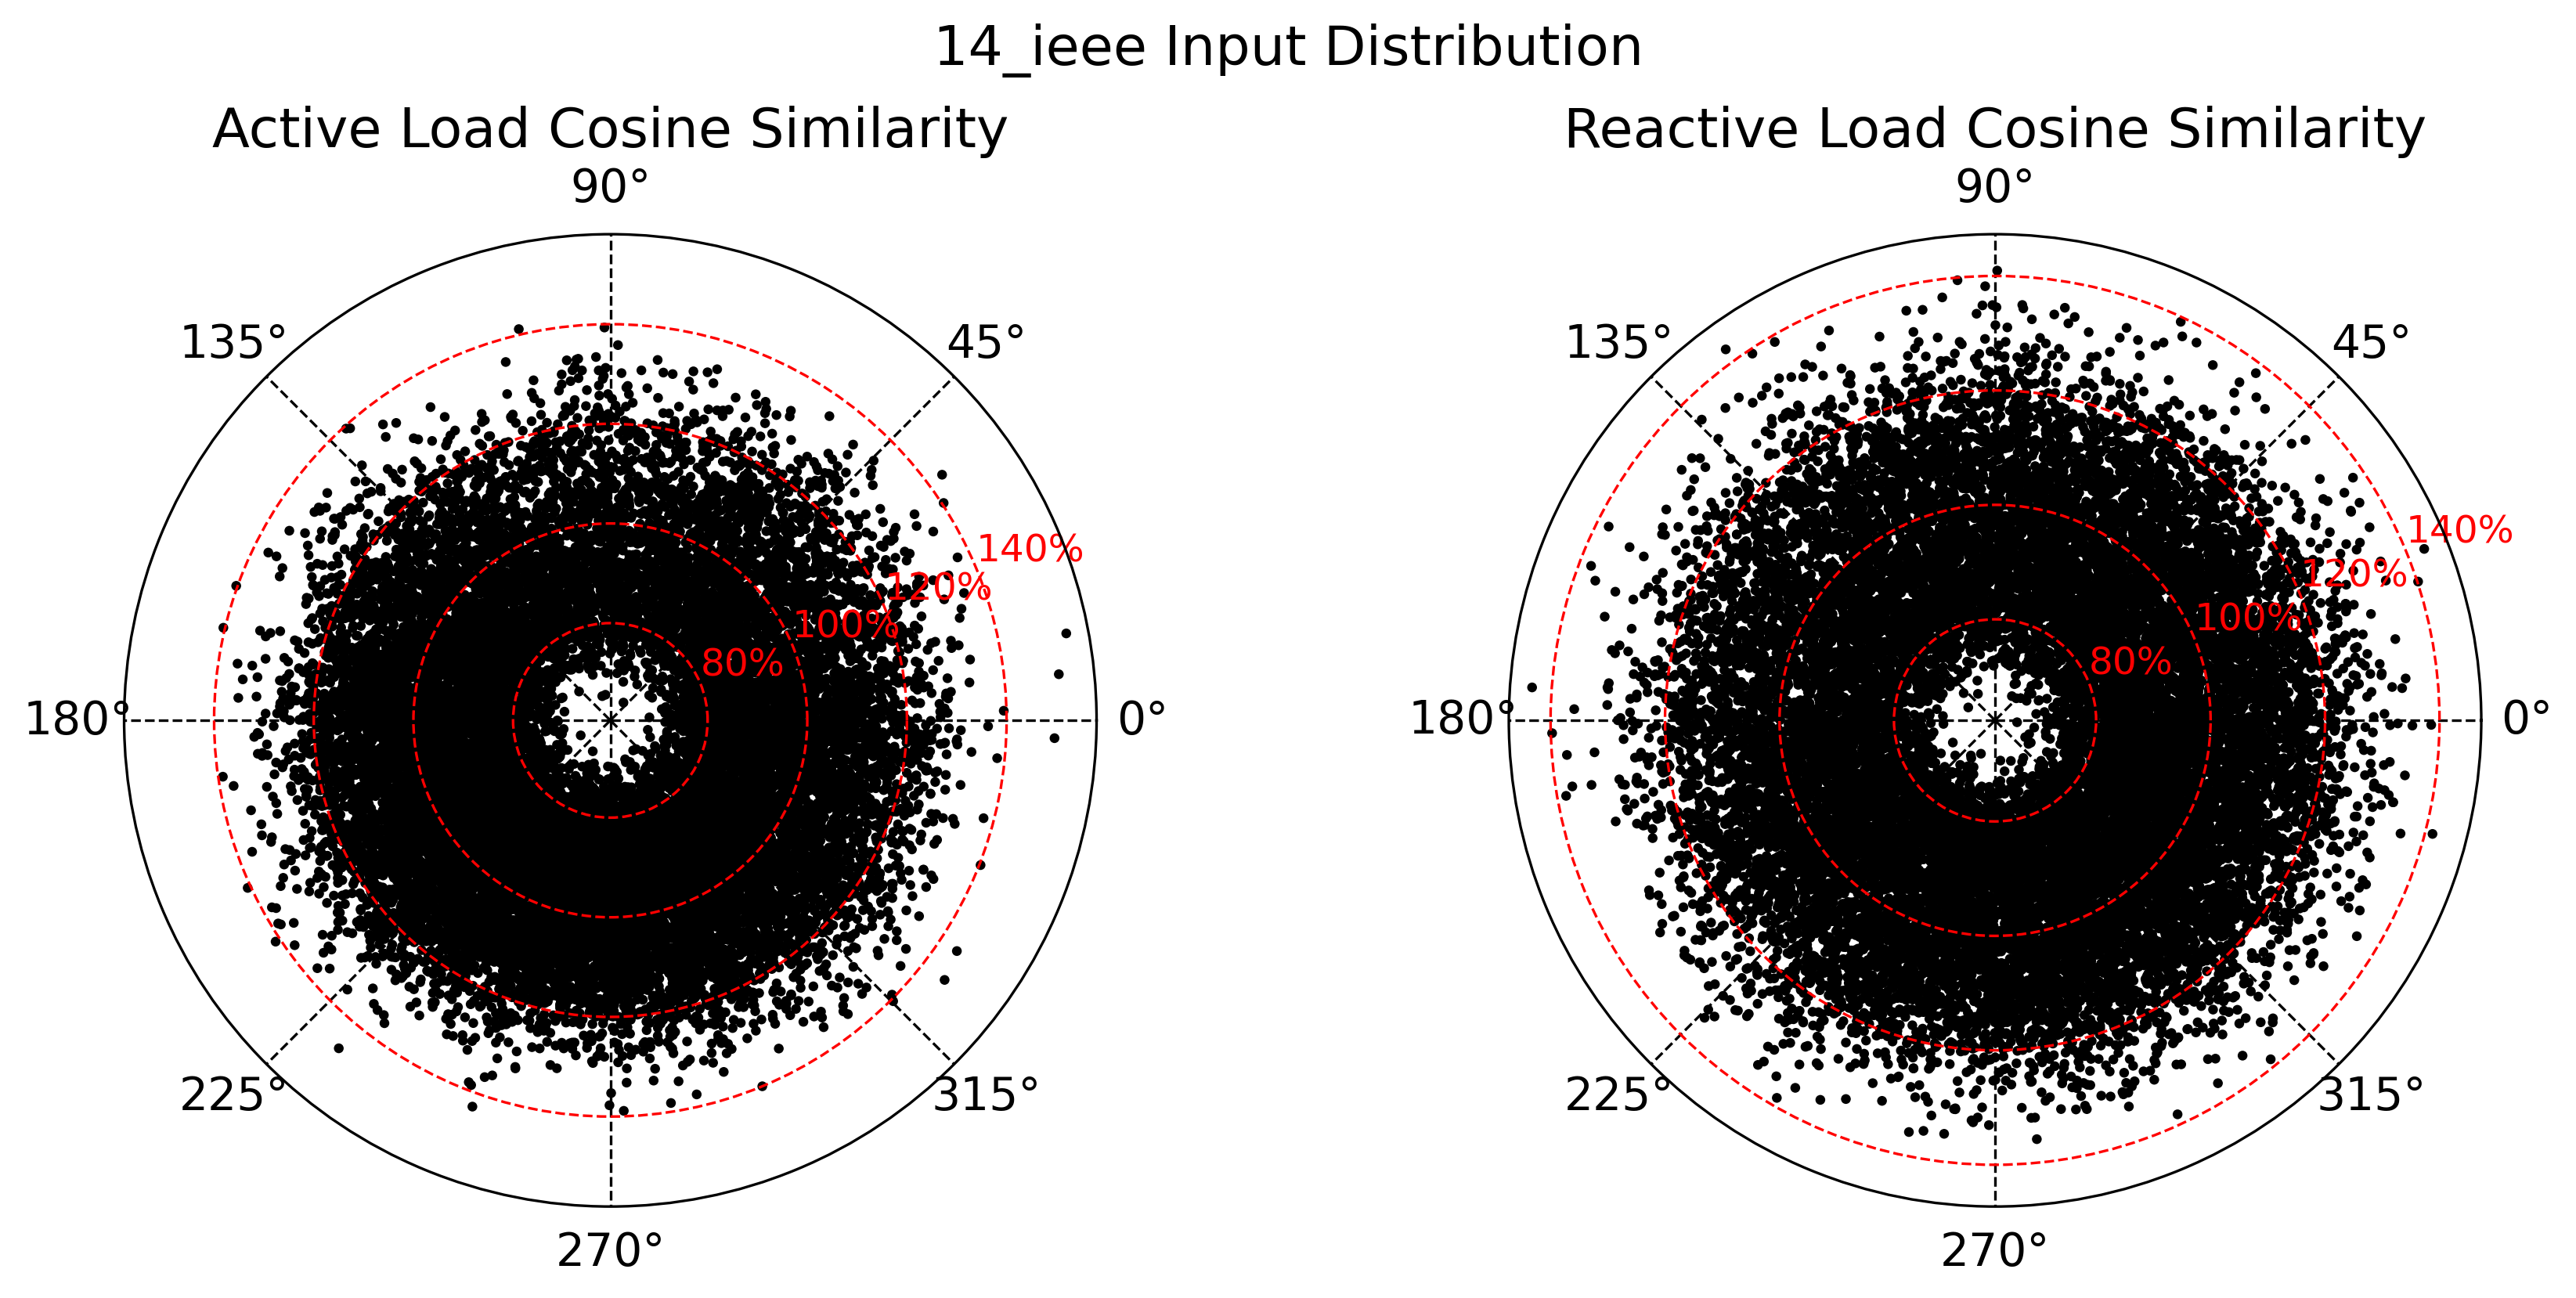

In [8]:
import matplotlib.pyplot as plt, matplotlib.ticker as mtick
import math
from numpy import dot
from numpy.linalg import norm
plt.rc('font', size=14)

def cosine_similarity(A, b):
    return np.array([dot(a, b)/(norm(a)*norm(b)) for a in A])

fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=300, subplot_kw={'projection': 'polar'}, )

for ax, key, component_name in zip(axs, ["pd", "qd"], ["Active Load", "Reactive Load"]):
    ref_load = ref["load"][key]
    theta = np.arccos(cosine_similarity(D_input["data"][key], ref_load)) * 180 / np.pi
    ax.scatter(
        theta, D_input["data"][key].sum(axis=1) / ref_load.sum(),
        marker='.', edgecolor='none', color='black',
    )
    ax: plt.Axes
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.2))
    ax.yaxis.set_tick_params(labelcolor='red', labelsize='small')
    ax.grid(visible=True, which='major', axis='y', color='red', linestyle='--')
    ax.grid(visible=True, which='major', axis='x', color='black', linestyle='--', zorder=0)

    ax.set_title(f"{component_name} Cosine Similarity")

fig.subplots_adjust(left=0.3, right=0.7)
fig.suptitle(f"{case_ref} Input Distribution", y=1.05)
fig.tight_layout();

Some load vectors correspond to infeasible samples. The plot marks AC-infeasible samples using red `x` and SOC-feasible but AC-infeasible samples using blue `+`.

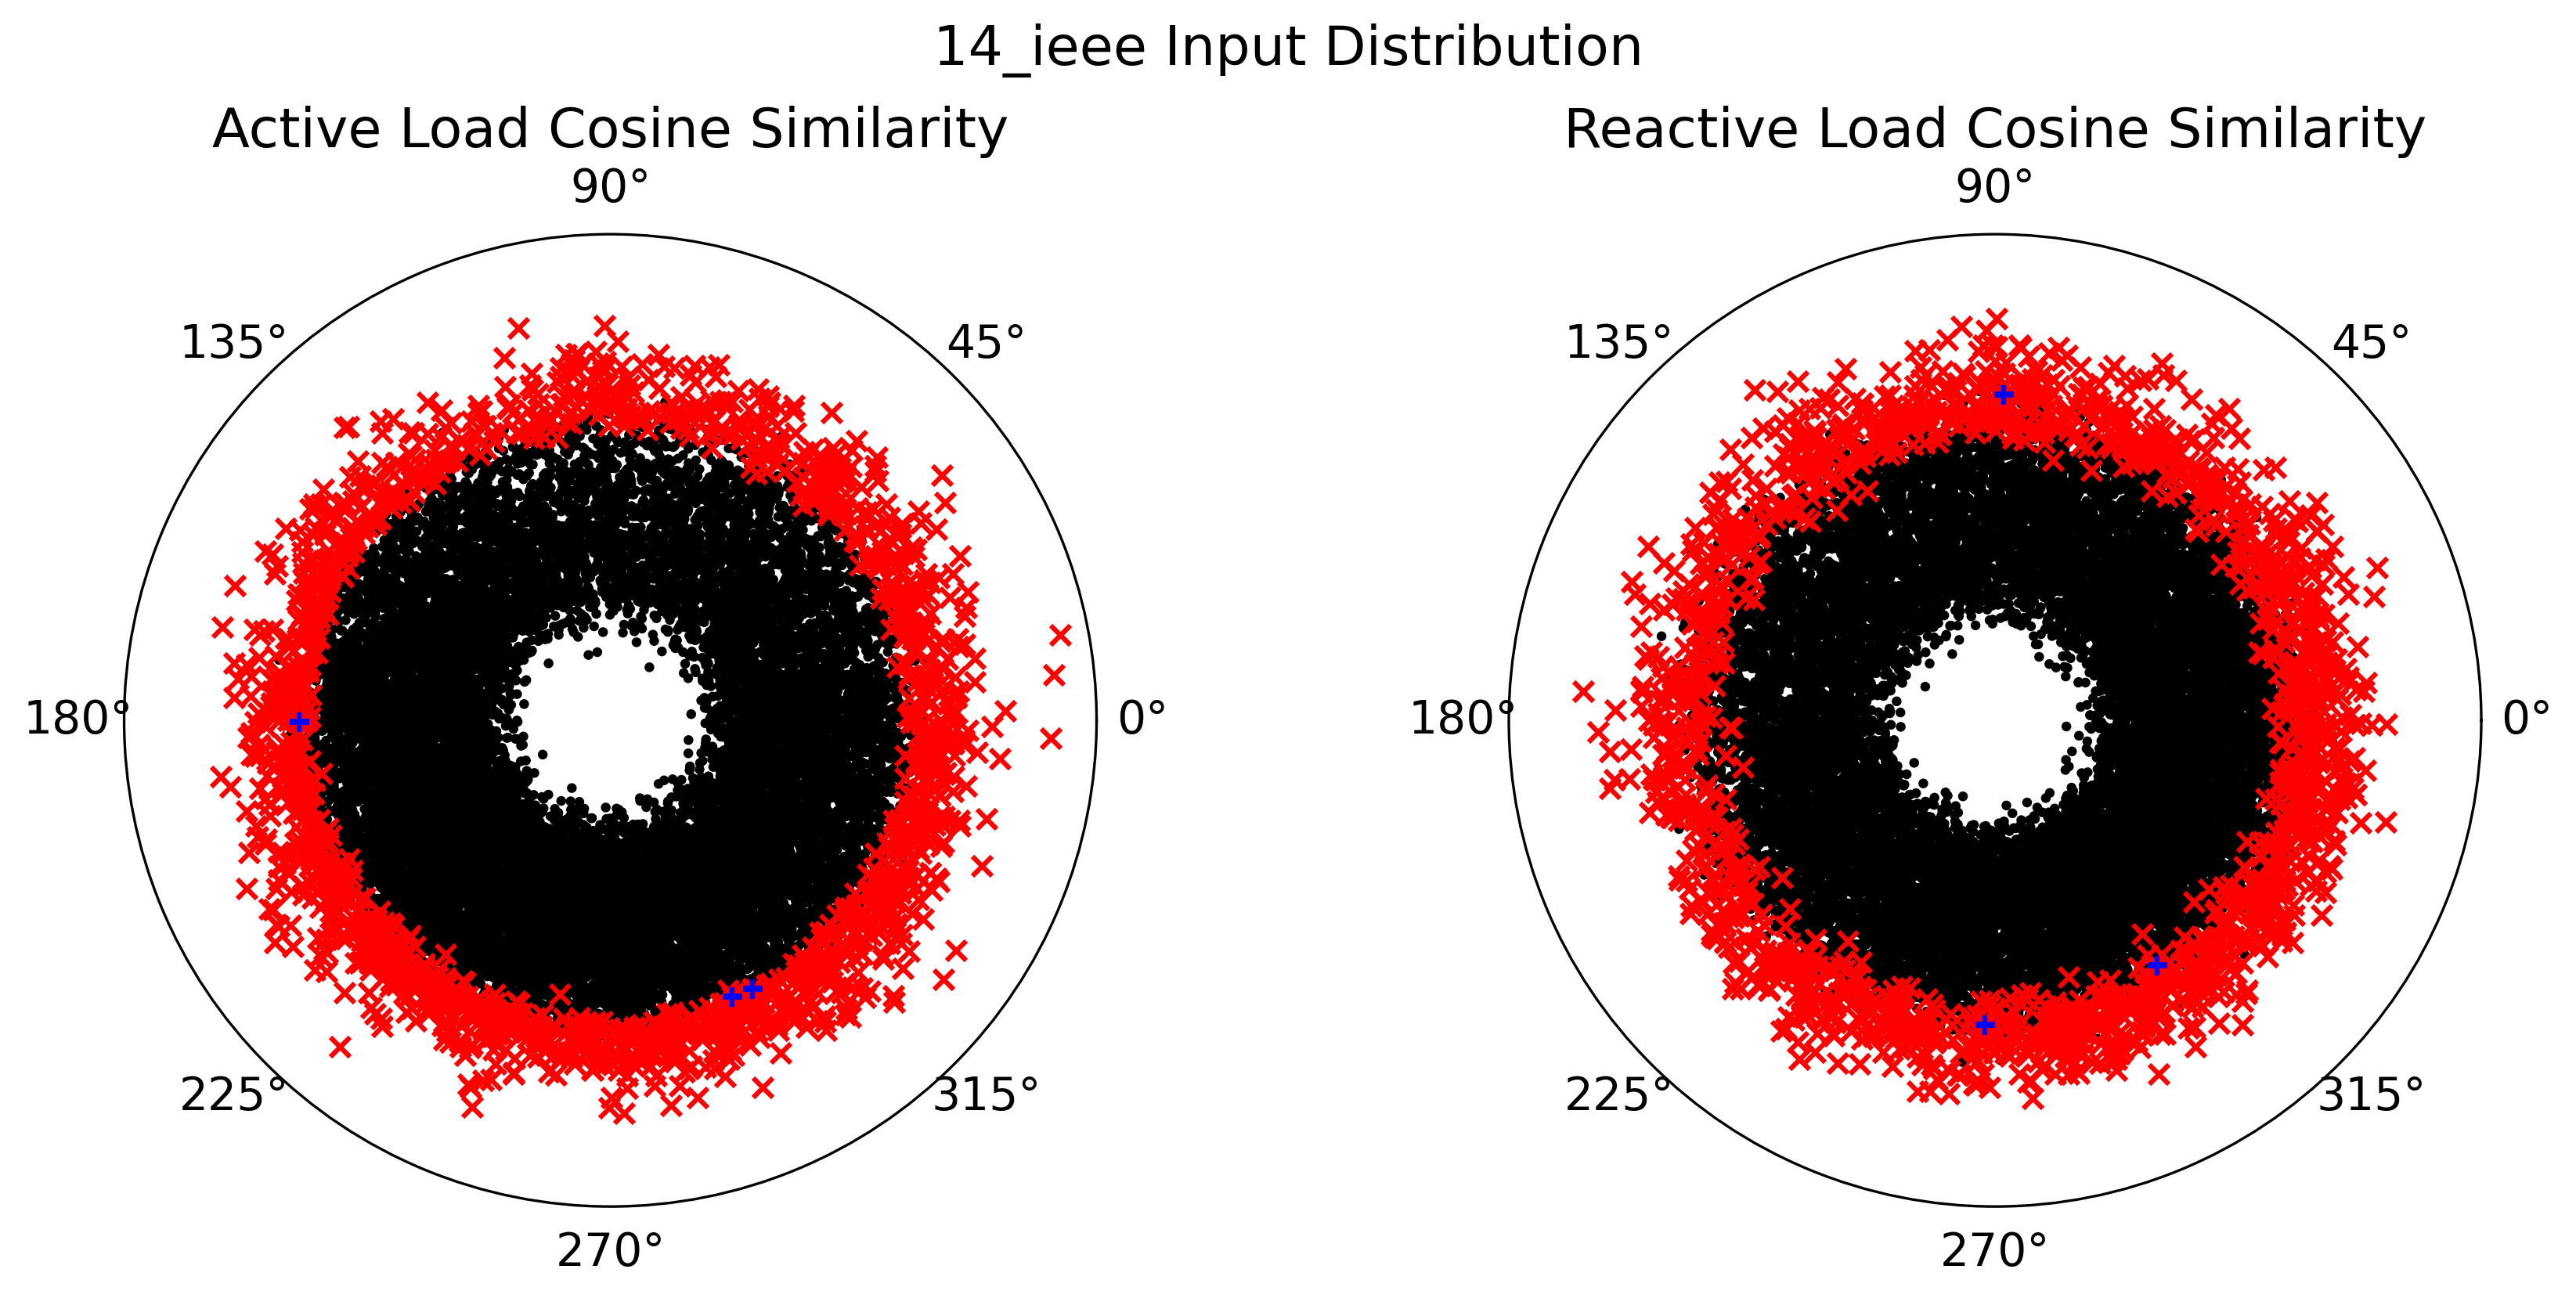

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=300, subplot_kw={'projection': 'polar'}, )

for ax, key, component_name in zip(axs, ["pd", "qd"], ["Active Load", "Reactive Load"]):
    ref_load = ref["load"][key]
    theta = np.arccos(cosine_similarity(D_input["data"][key], ref_load)) * 180 / np.pi
    ax.scatter(
        theta[all_feasible], D_input["data"][key][all_feasible].sum(axis=1) / ref_load.sum(),
        marker='.', edgecolor='none', color='black',
    )
    ax.scatter(
        theta[ac_infeasible], D_input["data"][key][ac_infeasible].sum(axis=1) / ref_load.sum(),
        marker='x', color='red',
    )
    ax.scatter(
        theta[soc_feasible_ac_infeasible], D_input["data"][key][soc_feasible_ac_infeasible].sum(axis=1) / ref_load.sum(),
        marker='+', color='blue',
    )
    ax.set_yticks([])
    ax.grid(False, axis='x')


    ax.set_title(f"{component_name} Cosine Similarity")
    ax.set_ylim(0.5, 1.6)
    

fig.subplots_adjust(left=0.3, right=0.7)
fig.suptitle(f"{case_ref} Input Distribution", y=1.05)
fig.tight_layout();

The function below visualizes the solutions of AC, DC, and SOC for a particular component's value (e.g., the example below shows the AC/DC/SOC-optimal active power injection of a generator).

In [10]:
def acp_dcp_soc_fig(total_load, ac_true, dc_true, soc_true, value_name, component_name, lower_bound=None, upper_bound=None, rows=2):
    """Comparison plot for ACOPF, DCOPF, and SOCWRConic solutions.
    
    Args:
        total_load (np.ndarray): Total load data. (n_samples, 1)
        ac_true (np.ndarray): ACOPF solution. (n_samples, n_components)
        dc_true (np.ndarray): DCOPF solution. (n_samples, n_components)
        soc_true (np.ndarray): SOCWRConic solution. (n_samples, n_components)
        value_name (str): Y-axis label.
        component_name (str): Name of the component.
        xmin (np.ndarray, optional): Lower bounds. Defaults to None.
        xmax (np.ndarray, optional): Upper bounds. Defaults to None.
        rows (int, optional): Number of rows of plots. Defaults to 2.
    """
    if ac_true is not None:
        n_components = ac_true.shape[1]
    elif dc_true is not None:
        n_components = dc_true.shape[1]
    elif soc_true is not None:
        n_components = soc_true.shape[1]
    else:
        raise ValueError("No solution data provided.")

    cols = math.ceil(n_components / rows)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, 5 * rows), dpi=150)
    axs = axs.flatten()

    for i in range(n_components):
        ax = axs[i]
        if dc_true is not None:
            ax.scatter(total_load[all_feasible], dc_true[all_feasible, i], label="DCOPF", color="black", marker='.')
        if soc_true is not None:
            ax.scatter(total_load[all_feasible], soc_true[all_feasible, i], label="SOCWRConic", color="blue", marker='x')
        if ac_true is not None:
            ax.scatter(total_load[all_feasible], ac_true[all_feasible, i], label="ACOPF", color="red", marker='+')
        ax.set_xlabel("Total Active Load (p.u.)")
        ax.set_ylabel(value_name)

        if lower_bound is not None:
            ax.axhline(y=lower_bound[i], color="black", linestyle="--", label="Bounds")
        if upper_bound is not None:
            ax.axhline(y=upper_bound[i], color="black", linestyle="--")

        ax.set_title(f"{component_name} {i}")
        
    axs[0].legend()
    fig.tight_layout()
    fig.suptitle(f"{case_ref} {component_name} Comparison", y=1.05)

    return fig, axs

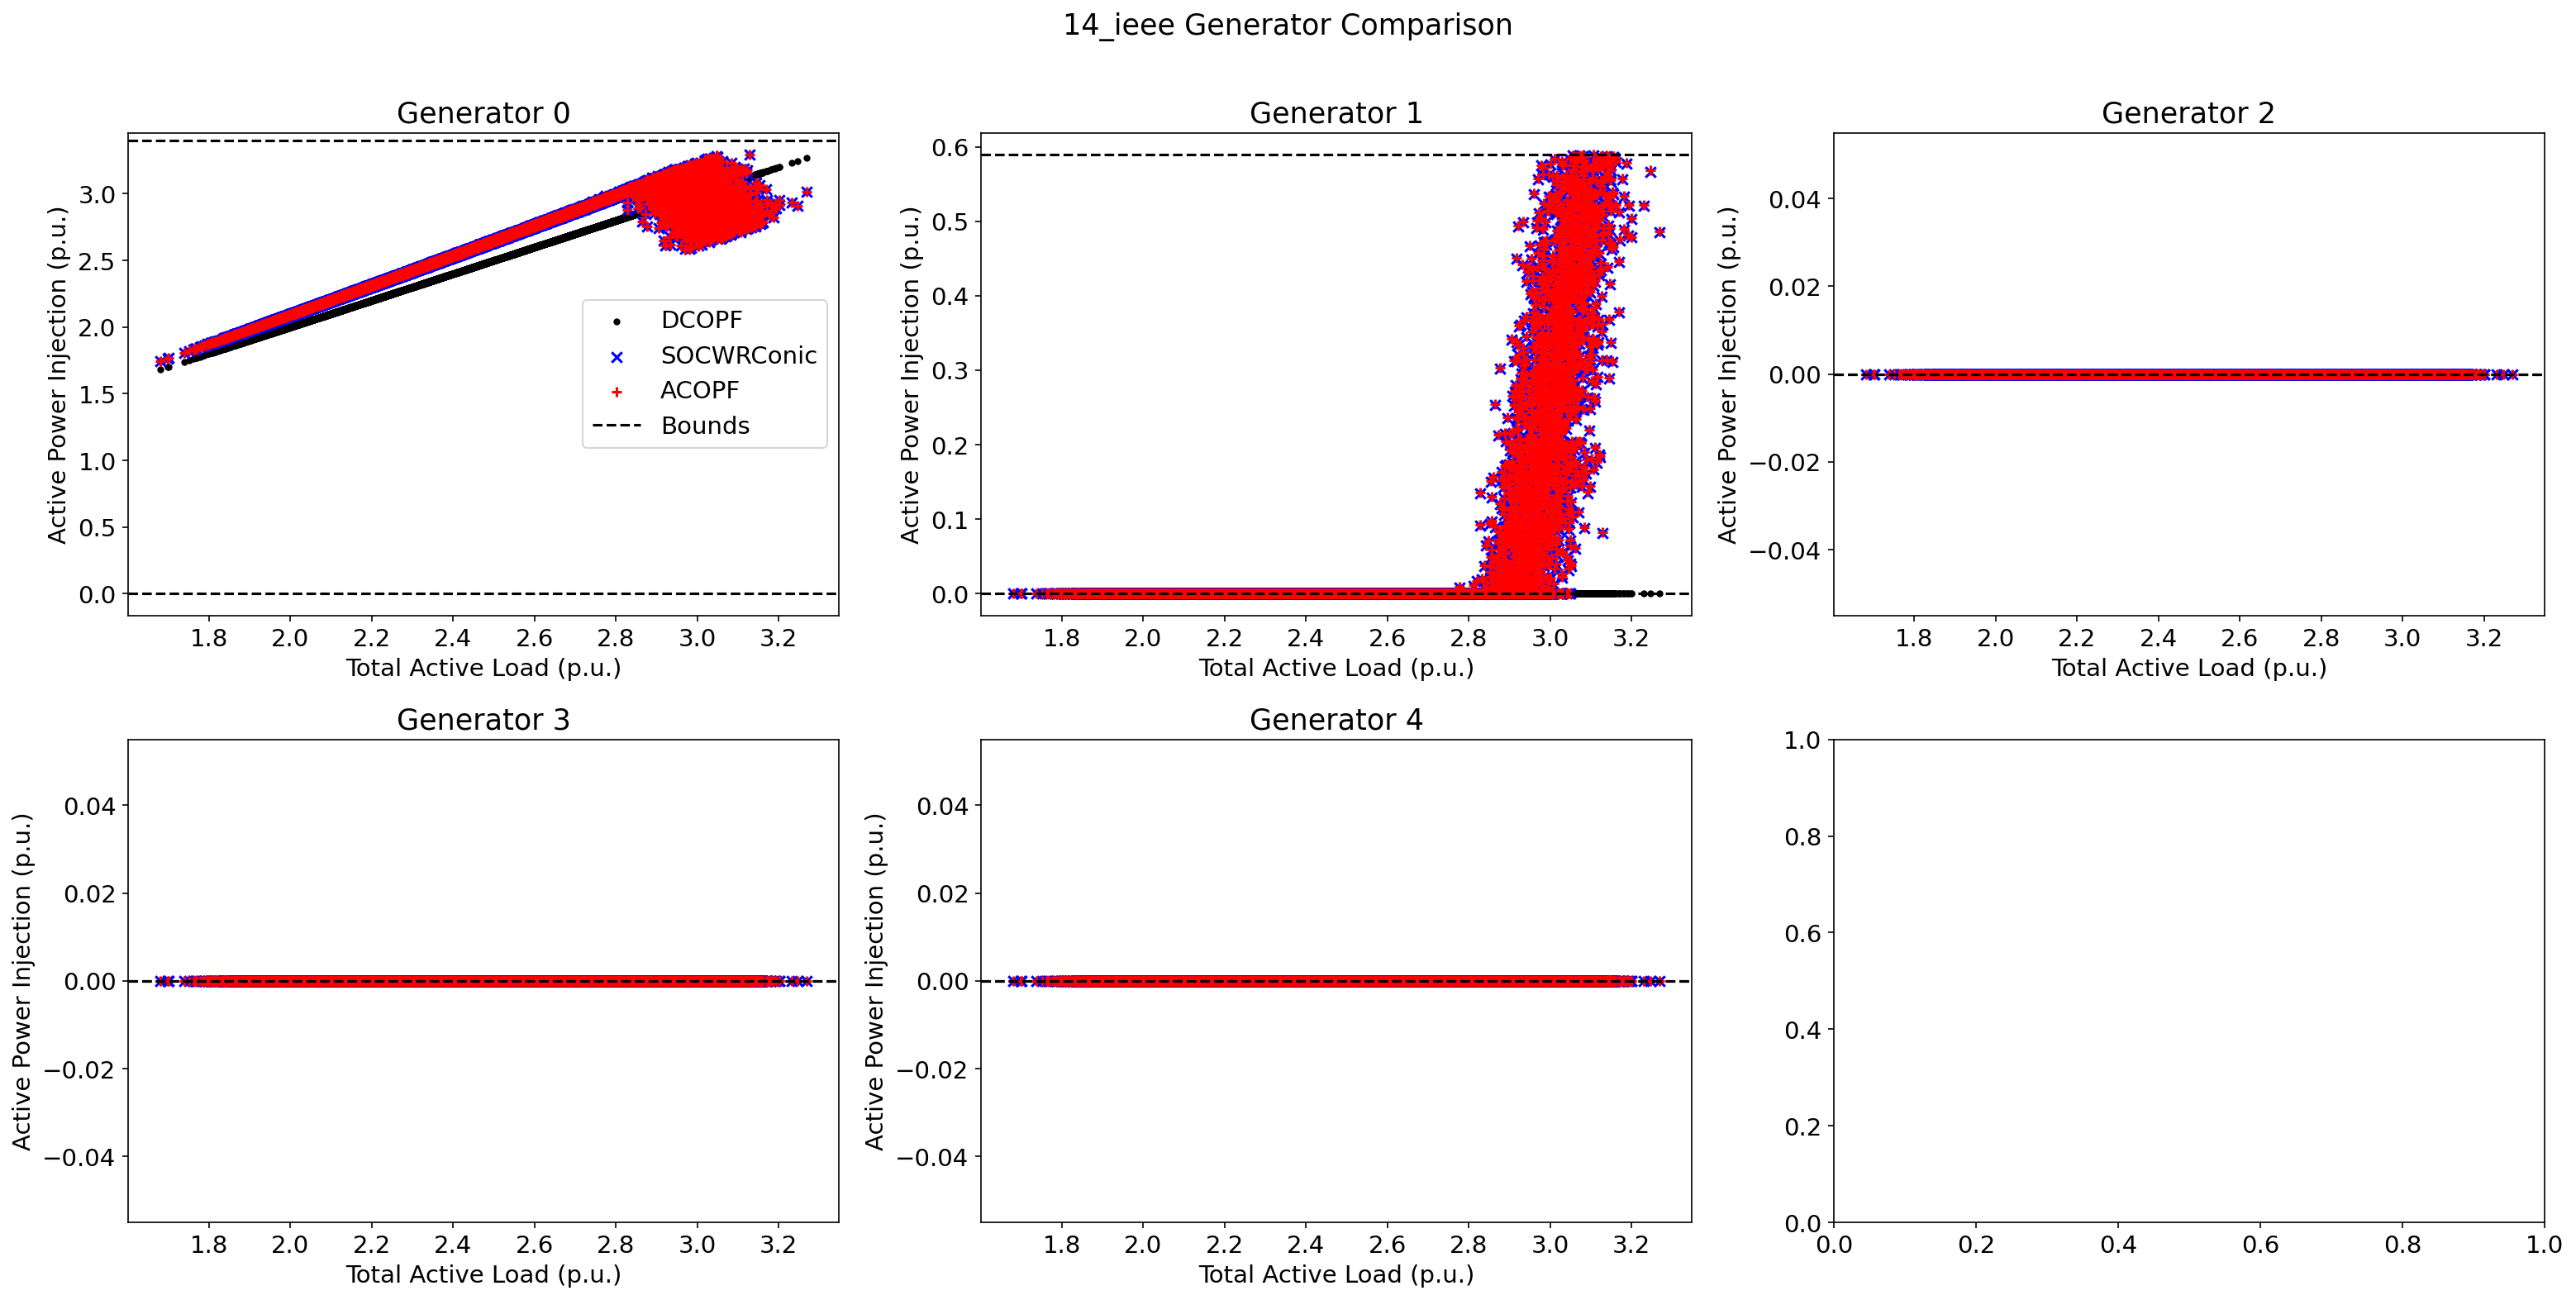

In [11]:
acp_dcp_soc_fig(
    total_load=D_input["data"]["pd"].sum(axis=1),
    ac_true=D_acp["primal"]["pg"],
    dc_true=D_dcp["primal"]["pg"],
    soc_true=D_soc["primal"]["pg"],
    value_name="Active Power Injection (p.u.)",
    component_name="Generator",
    lower_bound=ref["gen"]["pmin"],
    upper_bound=ref["gen"]["pmax"],
    rows=2,
);

### Visualize network

Install `networkx` to visualize the network.

In [ ]:
%pip install networkx

In [13]:
# read the json into a networkx graph
import networkx as nx

def make_network(path):
    with open(path, "r") as f:
        raw_json = json.load(f)
        file_data = raw_json["data"]

    G = nx.Graph()

    for bus in sorted(file_data["bus"].keys(), key=int):
        G.add_node(file_data["bus"][bus]["index"], type="bus", **file_data["bus"][bus])

    for branch in sorted(file_data["branch"].keys(), key=int):
        G.add_edge(file_data["branch"][branch]["f_bus"], file_data["branch"][branch]["t_bus"], **file_data["branch"][branch])

    for gen in file_data["gen"]:
        G.nodes[file_data["gen"][gen]["gen_bus"]]["generator"] = file_data["gen"][gen]
        G.nodes[file_data["gen"][gen]["gen_bus"]]["type"] = "generator"
    
    for load in file_data["load"]:
        _type = G.nodes[file_data["load"][load]["load_bus"]]["type"]
        G.nodes[file_data["gen"][gen]["gen_bus"]]["load"] = file_data["load"][load]
        G.nodes[file_data["load"][load]["load_bus"]]["type"] = "load" if _type != "generator" else "generator + load"

    for shunt in file_data["shunt"]:
        G.nodes[file_data["shunt"][shunt]["shunt_bus"]]["shunt"] = file_data["shunt"][shunt]

    return G

G = make_network(data_folder / f"{case_ref}.ref.json")

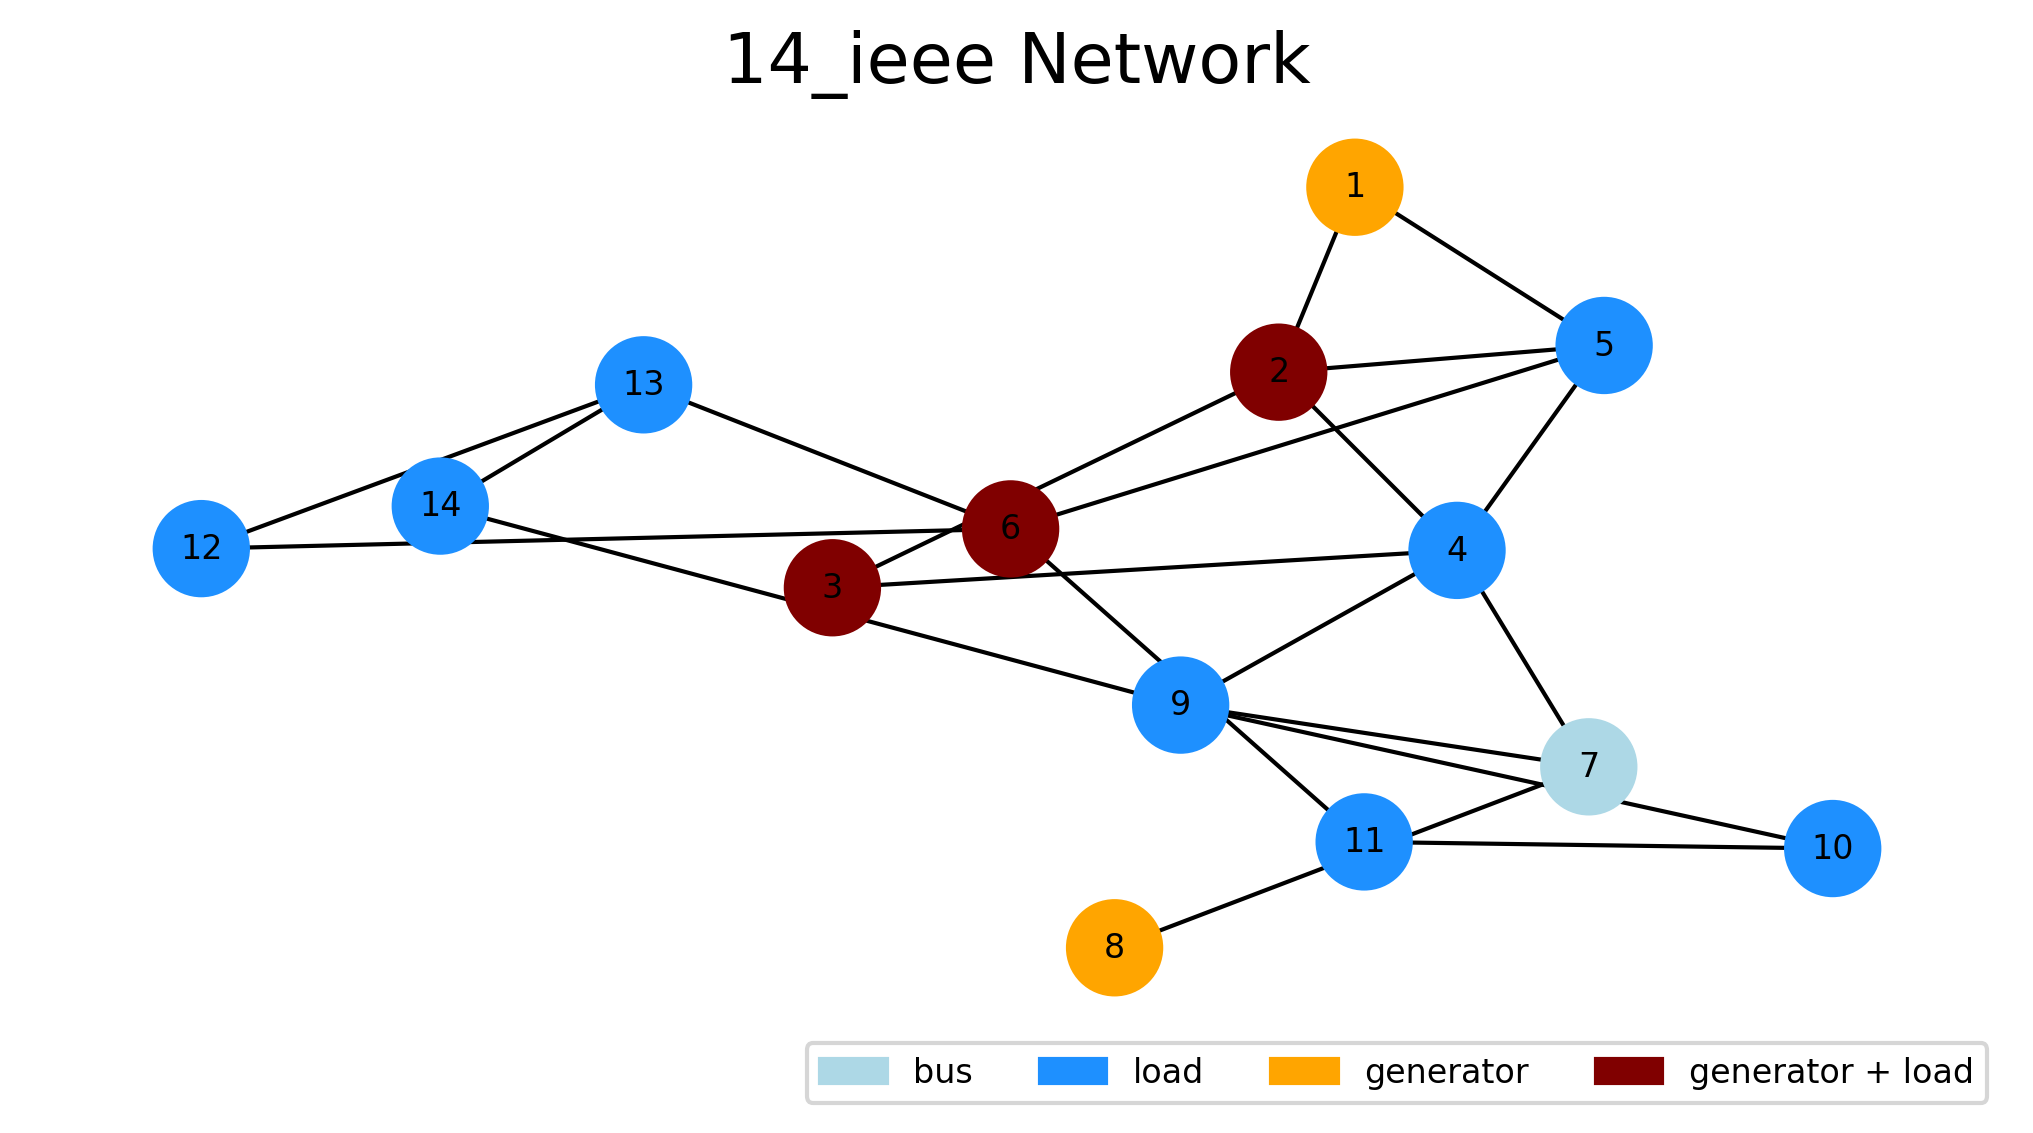

In [14]:
# draw the network
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)

node_colors = {
    "bus": "lightblue",
    "load": "dodgerblue",
    "generator": "orange",
    "generator + load": "maroon",
}

nx.draw(
    G=G,
    pos=nx.spring_layout(G, k=1, seed=42),
    ax=ax,
    node_color=[node_colors[G.nodes[n]["type"]] for n in G.nodes],
    with_labels=True,
    node_size=500,
    edge_color="black",
    font_size=8
)

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in node_colors.items()]
leg = ax.legend(handles=legend_handles, loc="lower right", ncol=4, fontsize=8)
leg.set_bbox_to_anchor((1, -0.1))

ax.set_title(f"{case_ref} Network")
fig.tight_layout();